# Using k-means to estimate T-shirt size

<img src="./images/t-shirts.png" style="width:620px"/>

A classical and simple case where k-means can be useful is when
we trying to estimate the sizes for t-shirts.

A company that is producing T-shirts wants to select several different 
sizes that will be applicable for all sizes.  Instead of making t-shirts
for all possible sizes in an increasing fashion (like for example 14, 14 1/2,
15, 16 ...) the factory prefers to group the body types to a specific set of
clustert (like small - medium - large - extra large for example).

Let's see how we can solve this problem using the k-means algorithm.

# The dataset

We will use the **ANSUR II** dataset is made available publicly in 2017 from the Anthropometric Survey of US Army Personnel.

The dataset contains 93 different measure for over 6K adults and can be downloaded 
from several different servers; in our case we can download it from 

https://www.kaggle.com/datasets/seshadrikolluri/ansur-ii





In [1]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.ensemble import RandomForestClassifier

In [2]:
def show_correlation_graph(data, title=None, cmap=None, linewidths=0, figsize=(9, 6), annot=True):
    """Utility to plot the correlation graph for the passed in data."""
    if cmap is None:
        cmap = sns.diverging_palette(10, 120, as_cmap=True)
    data = data.dropna()    
    corr = data.corr()
    for column_name in corr.columns:
        corr[column_name] = corr[column_name].abs()
    _, ax = plt.subplots(figsize=figsize)
    if title:
        ax.set_title(title)

    sns.heatmap(corr, annot=annot, fmt="2.2f", linewidths=linewidths, ax=ax, cmap=cmap)    

In [3]:
filename = "ANSUR-II.csv"
df = pd.read_csv(f"./data/{filename}", encoding="latin-1")
df = df.sample(frac=1)
df = df.drop(["Gender", "Date", "subjectid"], axis=1)
df

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference
1179,296,1555,348,223,1413,260,190,441,382,303,...,Combat Arms,13A,Mississippi,1,NaN,1,42,74,240,Left hand
3783,213,1368,304,240,1263,256,196,418,366,294,...,Combat Arms,11B,Oklahoma,1,NaN,1,21,67,187,Right hand
2448,193,1419,344,236,1324,273,222,430,305,269,...,Combat Arms,11B,Louisiana,2,NaN,2,20,70,150,Right hand
2036,239,1439,328,233,1323,235,193,398,334,262,...,Combat Arms,11B,California,1,NaN,1,43,71,165,Right hand
2401,344,1408,336,252,1290,253,198,441,430,290,...,Combat Service Support,25B,Florida,2,NaN,2,22,66,230,Right hand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,209,1405,331,205,1318,231,199,423,328,271,...,Combat Arms,11C,New Jersey,2,NaN,2,23,71,155,Right hand
3614,220,1353,309,208,1273,248,200,398,344,244,...,Combat Service Support,12R,Florida,2,NaN,2,21,67,150,Right hand
2234,280,1424,333,242,1322,247,208,445,433,267,...,Combat Arms,12B,North Carolina,2,NaN,2,26,67,220,Right hand
3740,211,1455,324,232,1343,256,205,406,355,287,...,Combat Arms,11B,Oklahoma,1,NaN,1,25,72,180,Right hand


We can see that we have 4,082 rows and each row has 105 columns.
When we have so many features we need to try to reduce it; we can use both our intuition for the necessary columns but also we can
find the highly correlated features and remove them from the 
data set.

Our first step will be to limit our data set to only measurements
about the upper body which as we can see here removes a lot of 
the features:

In [4]:
keywords = ["arm", "chest", "waist", "shoulder"]
columns_to_use = []
for c in df.columns: 
    for k in keywords:
        if k.upper() in c.upper():
            columns_to_use.append(c)
            break
features = df[columns_to_use].copy()
features

,chestbreadth,chestcircumference,chestdepth,chestheight,forearmcenterofgriplength,forearmcircumferenceflexed,forearmforearmbreadth,forearmhandlength,shouldercircumference,shoulderelbowlength,shoulderlength,waistbacklength,waistbreadth,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion
1179,301,1178,313,1375,359,331,585,497,1250,383,160,511,382,1095,288,436,1119
3783,290,1075,252,1233,327,310,562,450,1199,347,150,442,323,896,220,377,1015
2448,256,928,220,1310,364,306,468,503,1119,374,167,455,261,730,184,361,1103
2036,292,1072,251,1266,350,316,582,484,1157,358,140,471,317,904,219,389,1038
2401,311,1221,295,1279,351,349,690,480,1320,353,154,470,378,1200,331,385,1014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,276,957,226,1277,333,278,541,476,1152,366,147,444,275,777,197,335,1090
3614,273,953,225,1229,320,291,534,441,1111,344,147,431,265,800,213,344,1011
2234,289,1123,272,1286,368,354,613,493,1256,351,149,488,334,1017,256,385,1026
3740,298,1064,241,1301,347,312,600,478,1183,352,137,455,304,828,198,336,1095


As we can see we are left with only 17 columns which makes our 
task potentially simpler.

At this point we need to check if there are correlations among the remaining columns and in this case we will need to remove them since they do not add much of predictive value but can increase the complexity of the training process.

To do so we can use the show_correlation_graph function that is 
implemented in this notebook:


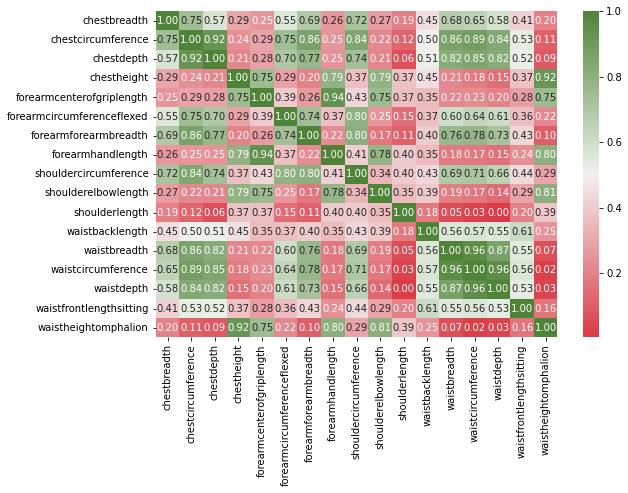

In [5]:
keywords = ["arm", "chest", "waist", "shoulder"]
columns_to_use = []
for c in df.columns: 
    for k in keywords:
        if k.upper() in c.upper():
            columns_to_use.append(c)
            break
features = df[columns_to_use].copy()
show_correlation_graph(features)


Visually inspecting the above picture we can see that indeed there are several data columns that are highly correlated; the following piece of code makes it easy to remove the highly correlated features.  

Note that in our case we are just hard-coding the 0.85 maximum correlation treshold limit and it is quite possible to change it several times following a trial and error process if the dataset requires it:

/tmp/ipykernel_242049/4244721909.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


,chestbreadth,chestcircumference,chestheight,forearmcenterofgriplength,forearmcircumferenceflexed,shouldercircumference,shoulderelbowlength,shoulderlength,waistbacklength,waistfrontlengthsitting
1179,301,1178,1375,359,331,1250,383,160,511,436
3783,290,1075,1233,327,310,1199,347,150,442,377
2448,256,928,1310,364,306,1119,374,167,455,361
2036,292,1072,1266,350,316,1157,358,140,471,389
2401,311,1221,1279,351,349,1320,353,154,470,385
...,...,...,...,...,...,...,...,...,...,...
3395,276,957,1277,333,278,1152,366,147,444,335
3614,273,953,1229,320,291,1111,344,147,431,344
2234,289,1123,1286,368,354,1256,351,149,488,385
3740,298,1064,1301,347,312,1183,352,137,455,336


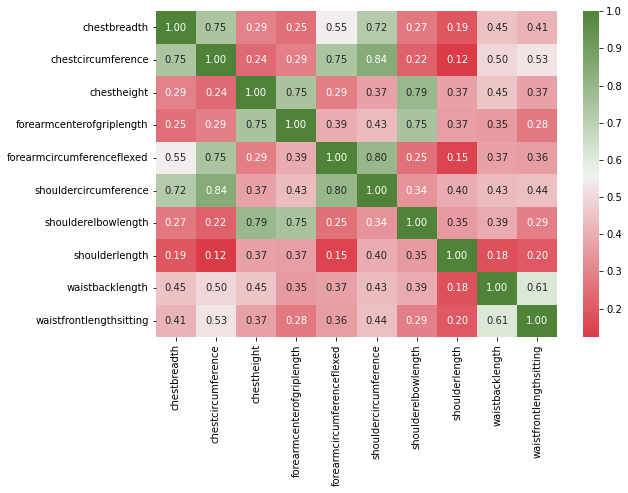

In [6]:
corr_matrix = features.corr().abs()
corr_matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
uncorrelated = features.drop(to_drop, axis=1)
display(uncorrelated)
show_correlation_graph(uncorrelated)

In [7]:
uncorrelated

,chestbreadth,chestcircumference,chestheight,forearmcenterofgriplength,forearmcircumferenceflexed,shouldercircumference,shoulderelbowlength,shoulderlength,waistbacklength,waistfrontlengthsitting
1179,301,1178,1375,359,331,1250,383,160,511,436
3783,290,1075,1233,327,310,1199,347,150,442,377
2448,256,928,1310,364,306,1119,374,167,455,361
2036,292,1072,1266,350,316,1157,358,140,471,389
2401,311,1221,1279,351,349,1320,353,154,470,385
...,...,...,...,...,...,...,...,...,...,...
3395,276,957,1277,333,278,1152,366,147,444,335
3614,273,953,1229,320,291,1111,344,147,431,344
2234,289,1123,1286,368,354,1256,351,149,488,385
3740,298,1064,1301,347,312,1183,352,137,455,336


As we can see now, we have removed the highly correlated features and we are left with only 10 columns that we will now use as input to the k-means algorithm trying to discover the optimal centroids.

Again intuitevely we will train the k-means algorirhm for all the centroids from 1 - 12 and using the **elbow** method we will find the best number of them.

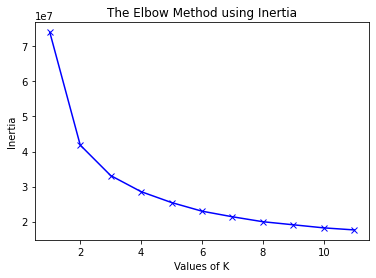

In [8]:
trials = []
models = {}
for n_clusters in range(1, 12):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(uncorrelated)
    models[n_clusters] = kmeans
    trials.append([n_clusters, kmeans.inertia_])

inertias = pd.DataFrame(trials, columns=["K", "V"])
inertias

plt.plot(inertias.K, inertias.V, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Visually inspecting the above graphical representation of the inertia of the model we conclude that 6 should be an applicable number of centroids for our dataset:

In [9]:
NUM_CLUSTERS = 6
model = models[NUM_CLUSTERS]

In [10]:
y = model.labels_
y

array([3, 1, 0, ..., 5, 1, 5], dtype=int32)

Our dataset has 10 dimentions thus it is impossible to visualize
as we would have done in a 2 or maximum 3 dimention space. 

One very usefull algorithm that we can use in this case is the PCA algorithm which allows for dimentionality reduction and can become handy and useful in many cases in ML.

In this notebook we will not analyze the math behind it but we will only use the sklearn provided algorith to solve the problem with a single line of code. 

Before we call the SkLearn function though we will need to scale the data in the same range to make them compatible with the PCA algorithm: 

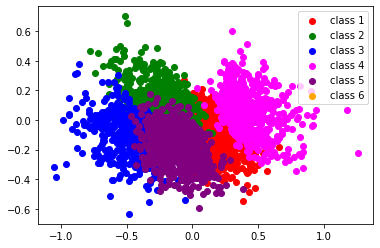

In [11]:
X = uncorrelated
X_norm = (X - X.min())/(X.max() - X.min())

pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X_norm))

colors = ["red", "green", "blue", "fuchsia", "purple", "orange"]

for cluster_id in range(1, NUM_CLUSTERS+1):
    label = f"class {cluster_id}"
    color = colors[cluster_id-1]
    plt.scatter(transformed[y==cluster_id][0], transformed[y==cluster_id][1], label=label, c=color)
    

plt.legend()
plt.show()


As we can see in the above picture the clusters appear to be quite comprehensive and 
stable. There are some outlier though but from what we see they do not distort the
data a lot; in the opposite situation we possibly would have to either remove them of somehow 
change the distribution of the data to normalize them.

Note that in this picture although we see it in 2 dimensions, the PCA algorithm is 
encapsulating all the dimentions using an algorithm that we will examine later.

In [12]:
X_norm

,chestbreadth,chestcircumference,chestheight,forearmcenterofgriplength,forearmcircumferenceflexed,shouldercircumference,shoulderelbowlength,shoulderlength,waistbacklength,waistfrontlengthsitting
1179,0.530303,0.581295,0.686603,0.547619,0.579882,0.665984,0.680,0.652778,0.595349,0.711443
3783,0.446970,0.433094,0.346890,0.293651,0.455621,0.561475,0.392,0.513889,0.274419,0.417910
2448,0.189394,0.221583,0.531100,0.587302,0.431953,0.397541,0.608,0.750000,0.334884,0.338308
2036,0.462121,0.428777,0.425837,0.476190,0.491124,0.475410,0.480,0.375000,0.409302,0.477612
2401,0.606061,0.643165,0.456938,0.484127,0.686391,0.809426,0.440,0.569444,0.404651,0.457711
...,...,...,...,...,...,...,...,...,...,...
3395,0.340909,0.263309,0.452153,0.341270,0.266272,0.465164,0.544,0.472222,0.283721,0.208955
3614,0.318182,0.257554,0.337321,0.238095,0.343195,0.381148,0.368,0.472222,0.223256,0.253731
2234,0.439394,0.502158,0.473684,0.619048,0.715976,0.678279,0.424,0.500000,0.488372,0.457711
3740,0.507576,0.417266,0.509569,0.452381,0.467456,0.528689,0.432,0.333333,0.334884,0.213930


In [13]:
columns = [
    "chestbreadth",
    "chestcircumference",
    "chestheight",
    "forearmcenterofgriplength",
    "forearmcircumferenceflexed",
    "shouldercircumference",
    "shoulderelbowlength",
    "shoulderlength",
    "waistbacklength",
    "waistfrontlengthsitting"
]

centroids = pd.DataFrame(model.cluster_centers_, columns=columns)

In [14]:
centroids

,chestbreadth,chestcircumference,chestheight,forearmcenterofgriplength,forearmcircumferenceflexed,shouldercircumference,shoulderelbowlength,shoulderlength,waistbacklength,waistfrontlengthsitting
0,277.887446,978.385281,1322.896104,354.974026,295.836941,1136.199134,371.353535,151.544012,472.855700,376.656566
1,286.920744,1048.281800,1252.249511,339.179061,306.679061,1162.598826,353.846380,146.300391,468.404110,380.567515
2,295.343793,1079.709413,1347.862210,363.251023,317.601637,1203.406548,379.001364,153.754434,491.532060,401.203274
3,313.636598,1209.876289,1344.737113,365.322165,342.149485,1288.940722,377.500000,156.172680,506.904639,417.077320
4,267.970962,941.947368,1233.715064,332.034483,284.471869,1091.406534,347.411978,144.588022,451.005445,361.891107
5,301.958273,1140.142446,1272.319424,346.853237,323.623022,1225.699281,359.687770,149.470504,485.956835,398.683453


 Since the measurements are in millimeters (expect from mass wihci is hectograms but we do not have them here) let's convert all the data to centimeters:

In [15]:
centroids_adj  = centroids / 25.4
centroids_adj

,chestbreadth,chestcircumference,chestheight,forearmcenterofgriplength,forearmcircumferenceflexed,shouldercircumference,shoulderelbowlength,shoulderlength,waistbacklength,waistfrontlengthsitting
0,10.940451,38.519106,52.082524,13.975355,11.647124,44.732249,14.620218,5.966300,18.616366,14.828999
1,11.296092,41.270937,49.301162,13.353506,12.073979,45.771607,13.930960,5.759858,18.441107,14.982973
2,11.627708,42.508245,53.065441,14.301221,12.504001,47.378211,14.921314,6.053324,19.351656,15.795404
3,12.347898,47.632925,52.942406,14.382762,13.470452,50.745698,14.862205,6.148531,19.956876,16.420367
4,10.550038,37.084542,48.571459,13.072224,11.199680,42.968761,13.677637,5.692442,17.756120,14.247681
5,11.888121,44.887498,50.091316,13.655639,12.741064,48.255877,14.160936,5.884665,19.132159,15.696199


In [17]:
uncorrelated

,chestbreadth,chestcircumference,chestheight,forearmcenterofgriplength,forearmcircumferenceflexed,shouldercircumference,shoulderelbowlength,shoulderlength,waistbacklength,waistfrontlengthsitting
1179,301,1178,1375,359,331,1250,383,160,511,436
3783,290,1075,1233,327,310,1199,347,150,442,377
2448,256,928,1310,364,306,1119,374,167,455,361
2036,292,1072,1266,350,316,1157,358,140,471,389
2401,311,1221,1279,351,349,1320,353,154,470,385
...,...,...,...,...,...,...,...,...,...,...
3395,276,957,1277,333,278,1152,366,147,444,335
3614,273,953,1229,320,291,1111,344,147,431,344
2234,289,1123,1286,368,354,1256,351,149,488,385
3740,298,1064,1301,347,312,1183,352,137,455,336


In [20]:
uncorrelated["label"] = pd.DataFrame(model.labels_)


In [21]:
def noninal_to_categories(df, column_name):
    temp = df.copy()
    return pd.get_dummies(temp[column_name], prefix=column_name)

In [22]:
Y = noninal_to_categories(uncorrelated, "label")
uncorrelated = uncorrelated.drop(["label"], axis=1)

In [23]:
clf = RandomForestClassifier(n_estimators=100, max_features='sqrt')
clf.fit(uncorrelated , Y)

RandomForestClassifier(max_features='sqrt')

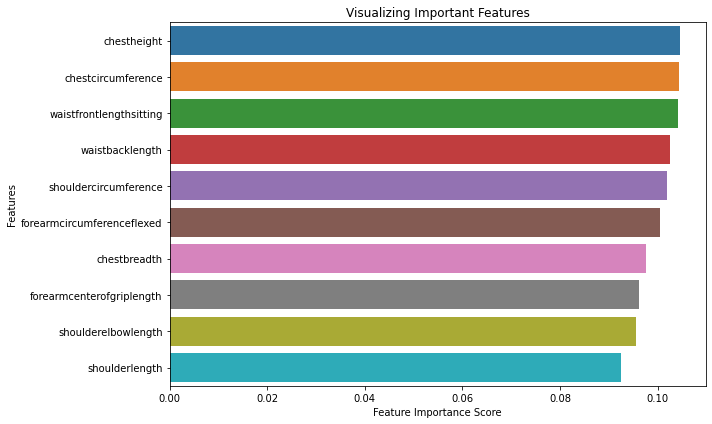

In [24]:
X_train = uncorrelated
feature_imp = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()